# ケーススタディ５： クラスタリング、次元圧縮

テーブルデータで、各レコード（行）を集約するのがクラスタリング、
特徴量（列）を集約するのが次元圧縮である。この２つは両方を併せて
使われることが多く、群としてデータを捉えるのに有効な手法である。

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# data (as pandas dataframes) 
X = wholesale_customers.data.features 
y = wholesale_customers.data.targets 
  
# metadata 
print(wholesale_customers.metadata) 
  
# variable information 
print(wholesale_customers.variables) 

{'uci_id': 292, 'name': 'Wholesale customers', 'repository_url': 'https://archive.ics.uci.edu/dataset/292/wholesale+customers', 'data_url': 'https://archive.ics.uci.edu/static/public/292/data.csv', 'abstract': 'The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 440, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Region'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5030X', 'creators': ['Margarida Cardoso'], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_description':

## データ前処理

In [11]:
import pandas as pd

X1 = pd.concat([X, y], axis=1)

X1.head(), X1.shape

(   Channel  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  Region
 0        2  12669  9656     7561     214              2674        1338       3
 1        2   7057  9810     9568    1762              3293        1776       3
 2        2   6353  8808     7684    2405              3516        7844       3
 3        1  13265  1196     4221    6404               507        1788       3
 4        2  22615  5410     7198    3915              1777        5185       3,
 (440, 8))

「教師なし学習」なので、X1にデータをまとめる

In [13]:
X1.isnull().sum()

Channel             0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
Region              0
dtype: int64

欠損値のないデータと分かる。

カテゴリカル変数について、度数分布を把握する。

In [16]:
X1['Channel'].value_counts()

Channel
1    298
2    142
Name: count, dtype: int64

In [17]:
X1['Region'].value_counts()

Region
3    316
1     77
2     47
Name: count, dtype: int64

次元圧縮のケーススタディなので「同レベルの特徴量」のみで分析（Region, Channelは削除）する。

In [19]:
X2 = X1.drop(['Channel', 'Region'], axis=1)

X2.head(), X2.shape

(   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
 0  12669  9656     7561     214              2674        1338
 1   7057  9810     9568    1762              3293        1776
 2   6353  8808     7684    2405              3516        7844
 3  13265  1196     4221    6404               507        1788
 4  22615  5410     7198    3915              1777        5185,
 (440, 6))

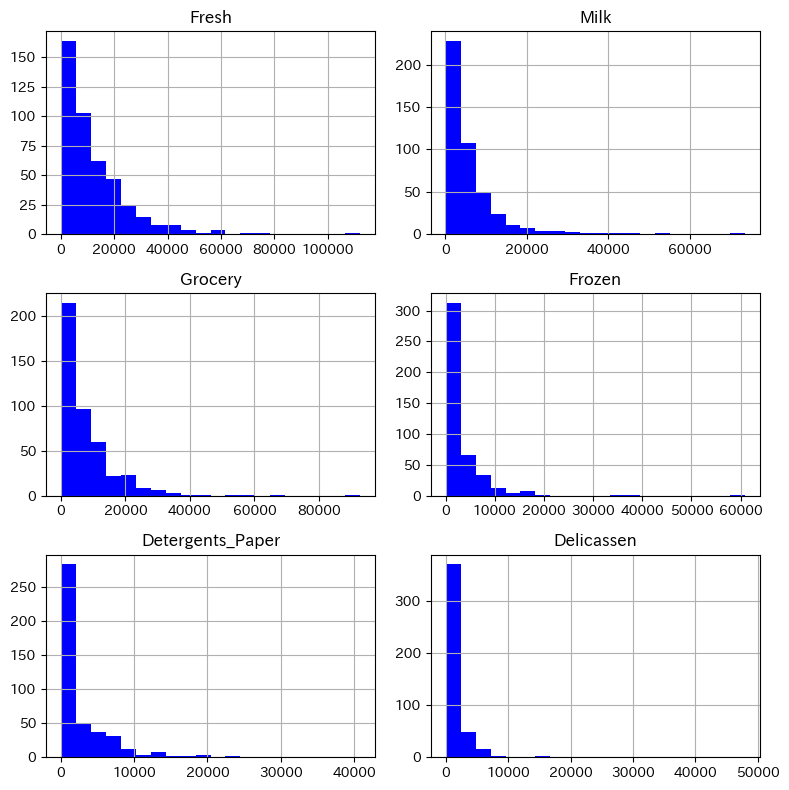

In [22]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from pylab import rcParams

rcParams['figure.figsize'] = (8, 8)
X2.hist(bins=20, color='b')
plt.tight_layout()

## クラスタリング

In [65]:
from sklearn.cluster import KMeans

clusters = 3 # which has to be smaller than the #attributes, i.e., #columns

algorithm = KMeans(n_clusters=clusters, random_state=123)

In [66]:
y_pred = algorithm.fit_predict(X2)

y_pred[:20]

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2],
      dtype=int32)

In [67]:
X_cluster = X2.groupby(y_pred).mean()

X_cluster

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,8723.78000,19220.540000,27604.860000,2724.700000,12277.340000,3195.360000
1,33111.69863,4918.465753,5847.547945,5554.027397,1097.876712,2097.123288
2,7655.48265,3881.015773,5335.798107,2555.113565,1810.236593,1129.605678


<Axes: >

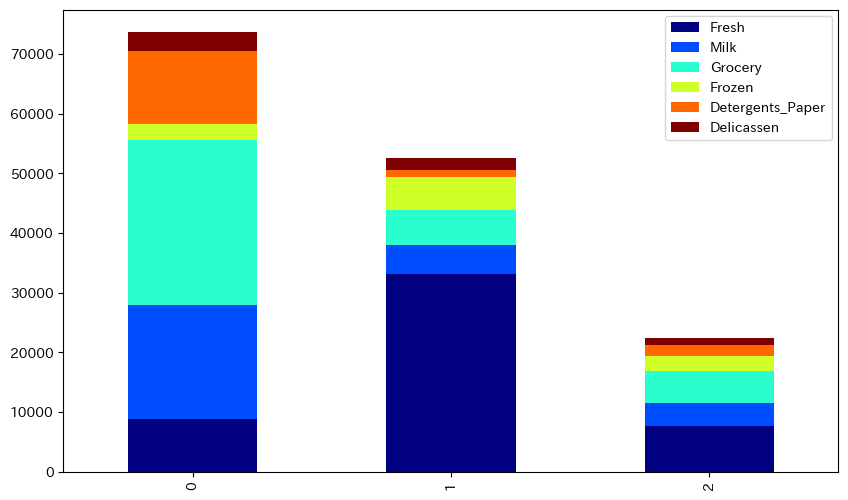

In [68]:
X_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='jet')

群０は、大量グループ、
群１は、Freshグループ（Freshの比重が大きい）、
群２は、少量グループ、と区別できる。

----- 大量グループ -----


/var/folders/lt/2bhwysg14ml43c8pjrzwjxs00000gn/T/ipykernel_11765/3256073179.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  w.hist(ax=ax, color='b')


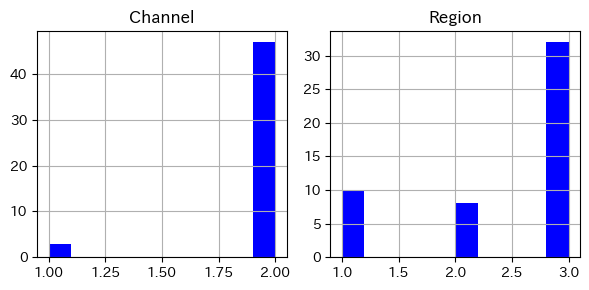

----- Freshグループ -----


/var/folders/lt/2bhwysg14ml43c8pjrzwjxs00000gn/T/ipykernel_11765/3256073179.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  w.hist(ax=ax, color='b')


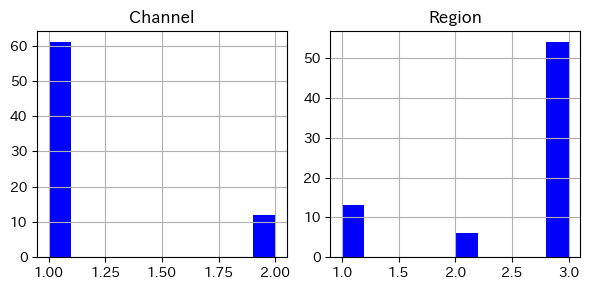

----- 少量グループ -----


/var/folders/lt/2bhwysg14ml43c8pjrzwjxs00000gn/T/ipykernel_11765/3256073179.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  w.hist(ax=ax, color='b')


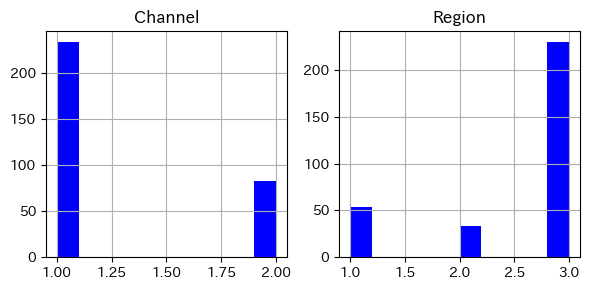

In [69]:
X3 = X1[['Channel', 'Region']]

rcParams['figure.figsize'] = (6, 3)

group_name = ['大量グループ', 'Freshグループ', '少量グループ']

for ii in range(clusters): # 群ごとにプロットする
    fig, ax = plt.subplots()
    w = X3[y_pred == ii]
    print(f'----- {group_name[ii]} -----')
    w.hist(ax=ax, color='b')
    plt.tight_layout()
    plt.show()



Regionの分布は大差がないが、Channelに特徴が明確に出ている。

--> 大量グループはChannel==2、それ以外はChannel==1に集中している。

## 次元圧縮

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [71]:
X4 = pca.fit_transform(X2)

X4[:5]

array([[  650.02212207,  1585.51909007],
       [-4426.80497937,  4042.45150884],
       [-4841.9987068 ,  2578.762176  ],
       [  990.34643689, -6279.80599663],
       [10657.99873116, -2159.72581518]])

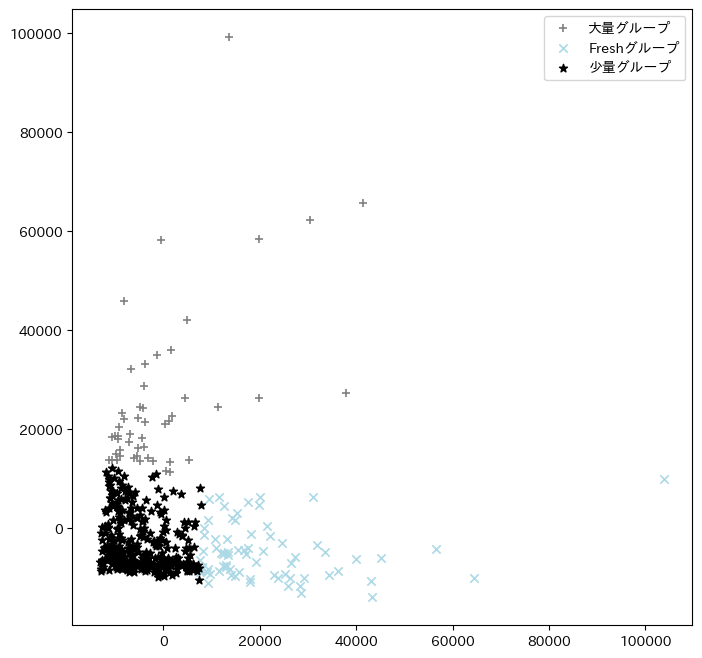

In [89]:
plt.figure(figsize=(8, 8))

marks = ['+', 'x', '*']
group_name = ['大量グループ', 'Freshグループ', '少量グループ'] # alr defined above
colors = ['grey', 'lightblue', 'black']

for ii in range(clusters):
    tmp = X4[y_pred == ii]
    plt.scatter(tmp[:, 0], tmp[:, 1], marker=marks[ii], label=group_name[ii], c=colors[ii])

plt.legend()

クラスタリングは、ユークリッド空間的な意味があるので分かり易いが、
次元圧縮は、視覚的に分かり易いものの、縦横軸が何なのか不明なので、どのように解釈すべきか、は議論できない。

単に２次元にして、分布状態を視覚化するために使っている感じではある。また、次で見るように、外れ値を見つける
のにも使える。

## 例外値（外れ値）の分析

In [95]:
# X2は元データ、X4は次元圧縮後のデータ。X4データ空間上での条件でX2を絞り込めることが大切
X2[X4[:, 0] > 100000]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
181,112151,29627,18148,16745,4948,8550


In [96]:
X2[X4[:, 1] > 80000]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
85,16117,46197,92780,1026,40827,2944


In [97]:
X2.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000
